# Predicting Future NBA Hall of Famers using Supervised Machine Learning

**INTRO HERE**

This report will outline the process of creating an optimized machine learning model on 

First we will look at our raw data. We have gathered the following datasets to assist in predicting future Hall of Fame inductions:
1. Player statistics for each season played from 1950 - 2022
2. All star data from 1950 - 2022
3. Hall of fame statistics for training the labels
4. Final MVP Statistics from 1968 - 2023
5. Season MVP statistics from 1968 - 2023

In [163]:
import pandas as pd
# turn off warnings
import warnings
warnings.filterwarnings('ignore')

First we will view our player statistical data.

In [164]:
import os
player_stats_path = os.path.join('player_stats', 'player_stats.csv')
player_stats = pd.read_csv(player_stats_path)
# drop unnamed columns
player_stats.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
player_stats.head()

,Season,PLAYER_NAME,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,144.0,516.0,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,102.0,274.0,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,174.0,499.0,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,22.0,86.0,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,21.0,82.0,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [165]:
player_stats.columns

Index(['Season', 'PLAYER_NAME', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS'],
      dtype='object')

We now want to create a career summary for each player in the dataset. We will iterate over the player_stats dataframe, adding wanted columns to the dictionary. Note the shooting percentages are not included as they can be calculated afterwards.

In [166]:
to_sum = ['G', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
player_dict = {}

for row in player_stats.iterrows():
    row = row[1]
    cur = player_dict.get(row['PLAYER_NAME'], [[] for i in range(len(to_sum))])
    for index, col in enumerate(to_sum):
        cur[index].append(row[col])
    player_dict[row['PLAYER_NAME']] = cur

player_dict_new = {}
for player, values in player_dict.items():
    player_dict_new[player] = [sum(values[i]) for i in range(len(values))]

player_dict = player_dict_new
# remember to add max and min salaries at end of loop, and compute percentages
cols = ['PLAYER_NAME'] + to_sum
player_list = [[key] + value for key, value in player_dict.items()]

summary_df = pd.DataFrame(player_list, columns=cols)
summary_df.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Curly Armstrong,101.0,216.0,748.0,NaN,NaN,216.0,748.0,228.0,331.0,NaN,NaN,NaN,253.0,NaN,NaN,NaN,314.0,660.0
1,Cliff Barker,149.0,201.0,637.0,NaN,NaN,201.0,637.0,155.0,234.0,NaN,NaN,NaN,294.0,NaN,NaN,NaN,253.0,557.0
2,Leo Barnhorst,416.0,1555.0,4277.0,NaN,NaN,1555.0,4277.0,583.0,870.0,NaN,NaN,NaN,1342.0,NaN,NaN,NaN,1236.0,3693.0
3,Ed Bartels,47.0,68.0,269.0,NaN,NaN,68.0,269.0,62.0,114.0,NaN,NaN,NaN,52.0,NaN,NaN,NaN,112.0,198.0
4,Ralph Beard,126.0,749.0,2046.0,NaN,NaN,749.0,2046.0,508.0,660.0,NaN,NaN,NaN,551.0,NaN,NaN,NaN,228.0,2006.0


Now calculate each players 
- Career Field Goal Percentage
- Career Three-Point Field Goal Percentage
- Career 2-Point Pointer Percentage
- Career Effective Field Goal Percentage
- Career Free Throw Percentage

And their
- Offensive Rebounds Per Game
- Defensive Rebounds Per Game
- Total Rebounds Per Game
- Assists Per Game
- Steals Per Game
- Blocks Per Game
- Turnovers Per Game
- Personal Fouls Per Game
- Points Per Game

In [167]:
summary_df['FG%'] = summary_df['FG'] / summary_df['FGA']
summary_df['3P%'] = summary_df['3P'] / summary_df['3PA']
summary_df['2P%'] = summary_df['2P'] / summary_df['2PA']
summary_df['eFG%'] = (summary_df['FG'] + 0.5 * summary_df['3P']) / summary_df['FGA']
summary_df['FT%'] = summary_df['FT'] / summary_df['FTA']
summary_df['ORBPG'] = summary_df['ORB'] / summary_df['G']
summary_df['DRBPG'] = summary_df['DRB'] / summary_df['G']
summary_df['TRBPG'] = summary_df['TRB'] / summary_df['G']
summary_df['ASTPG'] = summary_df['AST'] / summary_df['G']
summary_df['STLPG'] = summary_df['STL'] / summary_df['G']
summary_df['BLKPG'] = summary_df['BLK'] / summary_df['G']
summary_df['TOVPG'] = summary_df['TOV'] / summary_df['G']
summary_df['PFPG'] = summary_df['PF'] / summary_df['G']
summary_df['PTSPG'] = summary_df['PTS'] / summary_df['G']
# fill null values with 0
summary_df.fillna(0, inplace=True)
# create player efficiency rating PER
summary_df['PER'] = (summary_df['PTS'] + summary_df['TRB'] + summary_df['AST'] + summary_df['STL'] + summary_df['BLK'] - summary_df['TOV']) / summary_df['G']

summary_df.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,ORBPG,DRBPG,TRBPG,ASTPG,STLPG,BLKPG,TOVPG,PFPG,PTSPG,PER
0,Curly Armstrong,101.0,216.0,748.0,0.0,0.0,216.0,748.0,228.0,331.0,...,0.0,0.0,0.0,2.504950,0.0,0.0,0.0,3.108911,6.534653,9.039604
1,Cliff Barker,149.0,201.0,637.0,0.0,0.0,201.0,637.0,155.0,234.0,...,0.0,0.0,0.0,1.973154,0.0,0.0,0.0,1.697987,3.738255,5.711409
2,Leo Barnhorst,416.0,1555.0,4277.0,0.0,0.0,1555.0,4277.0,583.0,870.0,...,0.0,0.0,0.0,3.225962,0.0,0.0,0.0,2.971154,8.877404,12.103365
3,Ed Bartels,47.0,68.0,269.0,0.0,0.0,68.0,269.0,62.0,114.0,...,0.0,0.0,0.0,1.106383,0.0,0.0,0.0,2.382979,4.212766,5.319149
4,Ralph Beard,126.0,749.0,2046.0,0.0,0.0,749.0,2046.0,508.0,660.0,...,0.0,0.0,0.0,4.373016,0.0,0.0,0.0,1.809524,15.920635,20.293651


Add number of seasons played, and the year of their first and last season.

In [168]:
player_names = summary_df['PLAYER_NAME']
# get the number of seasons played for each player
seasons_played = []
first_season = []
last_season = []
for player in player_names:
    player_df = player_stats[player_stats['PLAYER_NAME'] == player]
    first_season.append(player_df['Season'].min())
    last_season.append(player_df['Season'].max())
    seasons_played.append(len(player_stats[player_stats['PLAYER_NAME'] == player]))

summary_df['seasons_played'] = seasons_played
summary_df['first_season'] = first_season
summary_df['last_season'] = last_season

Add a column within the datafrane if the player is retired, which is found by if they have statistics in the most recent year

In [169]:
# add retired field
most_recent_season = player_stats['Season'].max()
player_stats_recent = player_stats[player_stats['Season'] == most_recent_season]
recent_players = player_stats_recent['PLAYER_NAME'].unique()
# create a new column in summary df called 'retired' if player is not in recent_players then they are retired
summary_df['retired'] = summary_df['PLAYER_NAME'].apply(lambda x: 1 if x not in recent_players else 0)
summary_df.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,STLPG,BLKPG,TOVPG,PFPG,PTSPG,PER,seasons_played,first_season,last_season,retired
0,Curly Armstrong,101.0,216.0,748.0,0.0,0.0,216.0,748.0,228.0,331.0,...,0.0,0.0,0.0,3.108911,6.534653,9.039604,2,1950,1951,1
1,Cliff Barker,149.0,201.0,637.0,0.0,0.0,201.0,637.0,155.0,234.0,...,0.0,0.0,0.0,1.697987,3.738255,5.711409,3,1950,1952,1
2,Leo Barnhorst,416.0,1555.0,4277.0,0.0,0.0,1555.0,4277.0,583.0,870.0,...,0.0,0.0,0.0,2.971154,8.877404,12.103365,7,1950,1954,1
3,Ed Bartels,47.0,68.0,269.0,0.0,0.0,68.0,269.0,62.0,114.0,...,0.0,0.0,0.0,2.382979,4.212766,5.319149,4,1950,1951,1
4,Ralph Beard,126.0,749.0,2046.0,0.0,0.0,749.0,2046.0,508.0,660.0,...,0.0,0.0,0.0,1.809524,15.920635,20.293651,2,1950,1951,1


## All Star Dataset

In [170]:
all_stars = pd.read_csv('all_stars_clean.csv')
summary_df = pd.merge(summary_df, all_stars, on='PLAYER_NAME', how='left')
summary_df['All_star_selections'].fillna(0, inplace=True)
summary_df.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,BLKPG,TOVPG,PFPG,PTSPG,PER,seasons_played,first_season,last_season,retired,All_star_selections
0,Curly Armstrong,101.0,216.0,748.0,0.0,0.0,216.0,748.0,228.0,331.0,...,0.0,0.0,3.108911,6.534653,9.039604,2,1950,1951,1,0.0
1,Cliff Barker,149.0,201.0,637.0,0.0,0.0,201.0,637.0,155.0,234.0,...,0.0,0.0,1.697987,3.738255,5.711409,3,1950,1952,1,0.0
2,Leo Barnhorst,416.0,1555.0,4277.0,0.0,0.0,1555.0,4277.0,583.0,870.0,...,0.0,0.0,2.971154,8.877404,12.103365,7,1950,1954,1,2.0
3,Ed Bartels,47.0,68.0,269.0,0.0,0.0,68.0,269.0,62.0,114.0,...,0.0,0.0,2.382979,4.212766,5.319149,4,1950,1951,1,0.0
4,Ralph Beard,126.0,749.0,2046.0,0.0,0.0,749.0,2046.0,508.0,660.0,...,0.0,0.0,1.809524,15.920635,20.293651,2,1950,1951,1,1.0


## Hall of Fame Dataset


In [171]:
hof = pd.read_csv('hof.csv')

# drop 'All_star_selections' column as we have that data cleaned and prepared
# drop other data as player statistics don't contain these values
hof.drop(['All_star_selections','height', 'weight', 'born', 'position'], axis=1, inplace=True)
hof.head()

,PLAYER_NAME,In_Hall_of_fame
0,Larry Foust,0
1,Brad Daugherty,0
2,Bill Laimbeer,0
3,Red Kerr,0
4,Red Rocha,0


Place labels on summary dataframe for later use

In [172]:
summary_df = summary_df.merge(hof, how='left', on='PLAYER_NAME')
summary_df.fillna(0, inplace=True)
summary_df.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,TOVPG,PFPG,PTSPG,PER,seasons_played,first_season,last_season,retired,All_star_selections,In_Hall_of_fame
0,Curly Armstrong,101.0,216.0,748.0,0.0,0.0,216.0,748.0,228.0,331.0,...,0.0,3.108911,6.534653,9.039604,2,1950,1951,1,0.0,0.0
1,Cliff Barker,149.0,201.0,637.0,0.0,0.0,201.0,637.0,155.0,234.0,...,0.0,1.697987,3.738255,5.711409,3,1950,1952,1,0.0,0.0
2,Leo Barnhorst,416.0,1555.0,4277.0,0.0,0.0,1555.0,4277.0,583.0,870.0,...,0.0,2.971154,8.877404,12.103365,7,1950,1954,1,2.0,0.0
3,Ed Bartels,47.0,68.0,269.0,0.0,0.0,68.0,269.0,62.0,114.0,...,0.0,2.382979,4.212766,5.319149,4,1950,1951,1,0.0,0.0
4,Ralph Beard,126.0,749.0,2046.0,0.0,0.0,749.0,2046.0,508.0,660.0,...,0.0,1.809524,15.920635,20.293651,2,1950,1951,1,1.0,0.0


# Initial Testing

As most players that play in the NBA don't make it to the hall of fame, we would like to only test on the upper echilon of players. To do this, we will use the Player Efficiency Rating (PER) to determine the top 25% of players and create our test set from this.

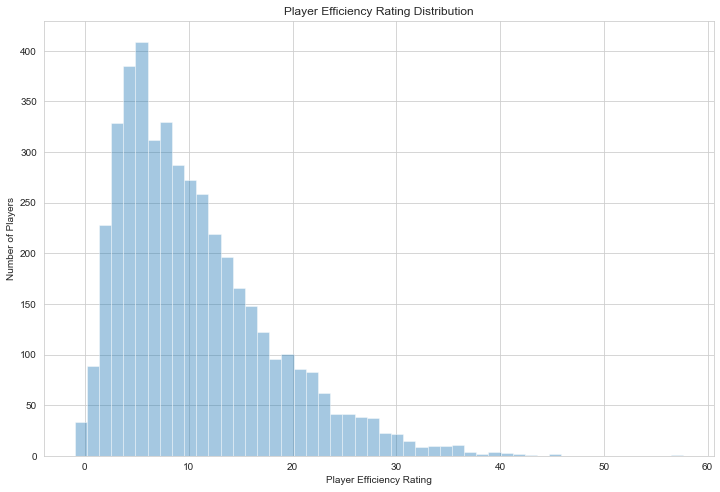

In [173]:
# plot PER distribution
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.distplot(summary_df['PER'], bins=50, kde=False)
plt.xlabel('Player Efficiency Rating')
plt.ylabel('Number of Players')
plt.title('Player Efficiency Rating Distribution')
plt.show()

In [174]:
# get the average PER from all star players
all_star_df = summary_df[summary_df['All_star_selections'] > 0]
all_star_df['PER'].mean()

24.945786536473285

In [175]:
skilled_players = summary_df[summary_df['PER'] >= 20]
# only keep retired players
skilled_players = skilled_players[skilled_players['retired'] == 1]
skilled_players.head()

,PLAYER_NAME,G,FG,FGA,3P,3PA,2P,2PA,FT,FTA,...,TOVPG,PFPG,PTSPG,PER,seasons_played,first_season,last_season,retired,All_star_selections,In_Hall_of_fame
4,Ralph Beard,126.0,749.0,2046.0,0.0,0.0,749.0,2046.0,508.0,660.0,...,0.0,1.809524,15.920635,20.293651,2,1950,1951,1,1.0,0.0
68,Alex Groza,130.0,1013.0,2136.0,0.0,0.0,1013.0,2136.0,899.0,1189.0,...,0.0,3.523077,22.500000,24.946154,2,1950,1951,1,1.0,0.0
114,Ed Macauley,641.0,3742.0,8589.0,0.0,0.0,3742.0,8589.0,3750.0,4929.0,...,0.0,2.600624,17.525741,20.769111,10,1950,1959,1,7.0,1.0
129,George Mikan,379.0,2961.0,7380.0,0.0,0.0,2961.0,7380.0,2536.0,3235.0,...,0.0,4.226913,22.316623,25.026385,6,1950,1956,1,4.0,1.0
182,Dolph Schayes,996.0,5863.0,15427.0,0.0,0.0,5863.0,15427.0,6712.0,7904.0,...,0.0,3.445783,18.512048,21.596386,15,1950,1964,1,12.0,1.0


In [176]:
# create pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


num_attrs = list(summary_df.drop(['PLAYER_NAME','In_Hall_of_fame','retired'], axis=1).columns)

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler())

preprocessing = ColumnTransformer([("num", num_pipeline, num_attrs)])

In [177]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def test_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = make_pipeline(preprocessing, model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [178]:
# create X and y and import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

X = skilled_players.drop(['PLAYER_NAME', 'In_Hall_of_fame', 'retired'], axis=1)
y = skilled_players['In_Hall_of_fame']

In [179]:
# run 50 cases of each model and get the average accuracy
models = [LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), SVC(), KNeighborsClassifier()]
models_cols = ['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier', 'GaussianNB', 'SVC', 'KNeighborsClassifier']
model_accuracies = []
for model in models:
    model_accuracy = []
    for i in range(50):
        model_accuracy.append(test_model(model, X, y))
    
    average = sum(model_accuracy) / len(model_accuracy)
    model_accuracies.append(average)

model_accuracies_df = pd.DataFrame(model_accuracies, index=models_cols, columns=['Average Accuracy'])
model_accuracies_df

,Average Accuracy
LogisticRegression,0.880506
RandomForestClassifier,0.866835
DecisionTreeClassifier,0.845570
GaussianNB,0.820253
SVC,0.855190
KNeighborsClassifier,0.821519


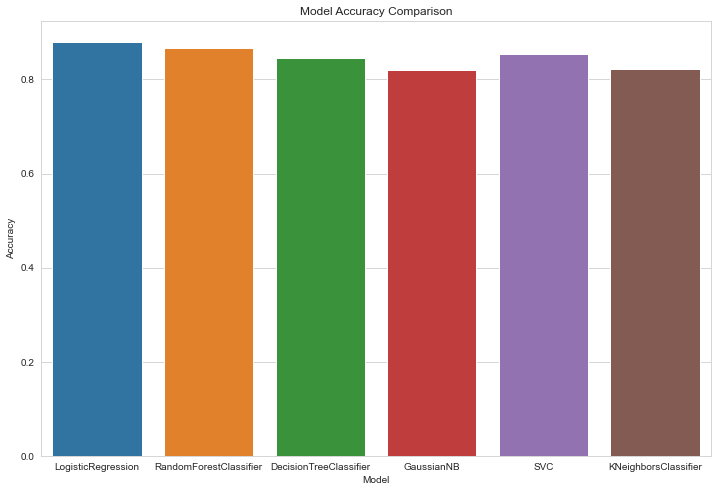

In [180]:
# plot results
plt.figure(figsize=(12, 8))
sns.barplot(x=models_cols, y=model_accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

# Logistic Regression Scored Highest

Now we will do some parameter optimization

In [181]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('lr', LogisticRegression())
])

# Parameter grid
param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear'],
    'lr__class_weight': [None, 'balanced'],
}

# Initialize Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Assuming X is your feature data and y is your target
X = skilled_players.drop(['PLAYER_NAME', 'In_Hall_of_fame', 'retired'], axis=1)
y = skilled_players['In_Hall_of_fame']

# Fit data to Grid Search
grid_search.fit(X, y)

# Best parameters
print("Best parameters: ", grid_search.best_params_)

# Best score
print("Best score: ", grid_search.best_score_)

Best parameters:  {'lr__C': 0.1, 'lr__class_weight': None, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Best score:  0.8623498864005195


In [182]:
# Extract best params
best_params = grid_search.best_params_

# Create a model with the best parameters
best_model = LogisticRegression(C=best_params['lr__C'], 
                                penalty=best_params['lr__penalty'],
                                solver=best_params['lr__solver'],
                                class_weight=best_params['lr__class_weight'])


best_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('lr', best_model)
])
X = skilled_players.drop(['PLAYER_NAME', 'In_Hall_of_fame', 'retired'], axis=1)
y = skilled_players['In_Hall_of_fame']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the new model
best_pipeline.fit(X_train, y_train)

# Now you can use best_model for predictions, scoring, etc.
y_pred = best_pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.9113924050632911

In [183]:
# Test on whole summary dataset
X = summary_df.drop(['PLAYER_NAME', 'In_Hall_of_fame', 'retired'], axis=1)
y = summary_df['In_Hall_of_fame']
y_pred = best_pipeline.predict(X)
accuracy_score(y, y_pred)

0.9759358288770054

In [196]:
# Predict player
def show_player_stats(player_name):
    player = summary_df[summary_df['PLAYER_NAME'] == player_name]
    return player

def predict_player(player_name):
    player = summary_df[summary_df['PLAYER_NAME'] == player_name]
    player = player.drop(['PLAYER_NAME', 'In_Hall_of_fame', 'retired'], axis=1)
    prediction = best_pipeline.predict(player)
    if int(prediction[0]) == 1:
        return 1
    else:
        return 0
    
predict_player('Trae Young')

0

In [198]:
# lets test players still in the league
players = summary_df[summary_df['retired'] == 0]

players['prediction'] = players['PLAYER_NAME'].apply(predict_player)

# keep only 'PLAYER_NAME' and 'prediction' columns
players = players[['PLAYER_NAME', 'prediction']]

# show players who are predicted to be in the hall of fame
players[players['prediction'] == 1]

,PLAYER_NAME,prediction
2909,Carmelo Anthony,1
2947,LeBron James,1
3003,Dwight Howard,1
3100,Chris Paul,1
3132,LaMarcus Aldridge,1
3224,Kevin Durant,1
3329,Russell Westbrook,1
3347,Stephen Curry,1
3361,James Harden,1
3414,Paul George,1
